In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.linalg as spla
# import tensorflow as tf
import torch
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms 
from torch.utils.data import DataLoader
from collections import OrderedDict
from tqdm import tqdm
from numpy.polynomial.chebyshev import chebval
from ml_collections import config_dict
import scipy.sparse as sparse
import os, sys
import time
from functools import partial
import ssgetpy

root_dir = r'../..'

plt.rc('font', weight='bold', size=20) 
plt.rc('legend', fontsize=16)
plt.rc('lines', linewidth=3, markersize=9)
mpl.rcParams['axes.grid'] = True

markers = ['o','^','s','p','d']
colors = ['b','g','r','c','m','y']

# Utils

In [2]:
def power_iteration(A,Omega,p, krylov=False):
    '''
    A: ndarray(shape=(m,n))
    Omega: ndarray(shape=(n,l))
    p: non-negative int
    Acol: ndarray(shape=(m,l)), ((A@A.T)**p)@A@Omega with orthonormalization
    '''
    A = A.astype(np.double)
    Omega = Omega.astype(np.double)
    l = Omega.shape[-1]
    X = (A@Omega).astype(np.double) #(m,l)
    Qcol,_ = spla.qr(X, mode='economic').astype(np.double) #(m,l)
    for iter in range(p):
        if krylov:
            Qrow,_ = spla.qr(A.T@Qcol, mode='economic') #(n,l*(iter+1))
            Qcol,_ = spla.qr(A @ np.hstack((Qrow,Omega)),mode='economic') #(m,l*(iter+2))
        else:
            Qrow,_ = spla.qr(A.T@Qcol[:,-l:], mode='economic') #(n,l)
            Qcol,_ = spla.qr(A@Qrow,mode='economic') #(m,l)
        Qrow = Qrow.astype(np.double)
        Qcol = Qcol.astype(np.double)
    return Qcol.astype(np.double)


def rsvd(A, k, l=None, power_iter=0, algo='rsvd', return_Omega=0, 
         embedding=lambda d,l: np.random.randn(d,l)/np.sqrt(l)):
    '''
    * algo: 'rsvd'(default, Halko2011), 'gn'(generalized Nystrom), 'bk'(block Krylov)
    * return_Omega: 0 = not return, 1 = return embedding, 2 = return embedding + distribution
    '''
    A = A.astype(np.double)
    if l is None:
        l = min(k+10, A.shape[1])

    # construct low-rank approximation
    if algo=='bk': # block krylov (ignoring l)
        Omega = embedding(A.shape[1],l).astype(np.double) #(n,l)
        Qcol = power_iteration(A,Omega,power_iter,krylov=True) #(m,l*(p+1))
        Uap_reduced, sap, Vhap = spla.svd(Qcol.T @ A, full_matrices=False, lapack_driver='gesvd') #(l*(p+1),l*(p+1)),(l*(p+1),),(l*(p+1),n)
        Uap = (Qcol @ Uap_reduced).astype(np.double) #(m,l*(p+1))
    elif algo=='gn': # generalized Nystrom
        l_large = np.ceil(1.5*k)
        Omega = embedding(A.shape[1],l).astype(np.double) #(n,l)
        Gamma = embedding(A.shape[0],l_large).astype(np.double) #(m,l_large)
        Qcol = power_iteration(A,Omega,power_iter) #(m,l)
        Qrow = power_iteration(A.T,Gamma,0) #(n,l_large)
        core = ((Qcol.T @ A) @ Qrow).astype(np.double) #(l,l_large)
        Uap_reduced, sap, Vhap_reduced = spla.svd(core, full_matrices=False, lapack_driver='gesvd') #(l,l),(l,),(l,l_large)
        Uap = (Qcol @ Uap_reduced).astype(np.double) #(m,l)
        Vhap = (Vhap_reduced @ Qrow.T).astype(np.double) #(l,n)
    else: # rsvd
        Omega = embedding(A.shape[1],l).astype(np.double) #(n,l)
        Qcol = power_iteration(A,Omega,power_iter) #(m,l)
        Uap_reduced, sap, Vhap = spla.svd(Qcol.T @ A, full_matrices=False, lapack_driver='gesvd') #(l,l),(l,),(l,n)
        Uap = (Qcol @ Uap_reduced).astype(np.double) #(m,l)
    
    # output
    if return_Omega==1:
        return Uap, sap, Vhap, Omega
    elif return_Omega==2:
        return Uap, sap, Vhap, Omega, embedding
    else:
        return Uap, sap, Vhap


def lupp(A):
    '''
    A of size mxk with rank k and m >= k
    
    A[p,:] = L@U
    p: ndarray(shape=(m,), dtype=int)
    L: ndarray(shape=(m,k), dtype=float)
    U: ndarray(shape=(k,k), dtype=float)
    '''
    A = A.astype(np.double)
    P, L, U = spla.lu(A)
    p = (P.T @ np.arange(A.shape[0]).reshape(-1,1)).astype(int).reshape(-1)
    return L.astype(np.double), U.astype(np.double), p


def cpqr(A):
    '''
    A of size kxn with rank k and n >= k
    
    A[:,p] = Q@R
    p: ndarray(shape=(n,), dtype=int)
    Q: ndarray(shape=(k,k), dtype=float)
    R: ndarray(shape=(k,n), dtype=float)
    '''
    A = A.astype(np.double)
    Q,R,p = spla.qr(A, mode='economic', pivoting=True)
    return Q.astype(np.double), R.astype(np.double), p.astype(int)


def stable_id_error(A, row_idx, timing=False, ord='fro'):
    A = A.astype(np.double)
    R = A[row_idx,:] #(k,n)
    t0 = time.time()
    Qr, _ = spla.qr(R.T, mode='economic') #(n,k)
    Qr = Qr.astype(np.double)
    A_sid = (A @ Qr) @ Qr.T 
    dt = time.time() - t0
    error = spla.norm(A - A_sid, ord=ord)
    if timing:
        return error, dt
    else:
        return error


def matdivide(A,B, compute_spectrum=False, tol=1e-16):
    '''
    A: (m,n) ndarray
    B: (k,n) ndarray
    compute A*pinv(B), or its spectrum
    '''
    A = A.astype(np.double)
    B = B.astype(np.double)
    U,s,Vh = spla.svd(B, full_matrices=False, lapack_driver='gesvd')
    r = np.count_nonzero(s>tol)
    Aux = ((A @ Vh[:r].T)/(s[:r].reshape(1,-1))).astype(np.double) #(m,r)
    if compute_spectrum:
        spectrum = spla.svd(Aux, compute_uv=False, lapack_driver='gesvd')
        return spectrum
    else:
        return (Aux @ U[:,:r].T).astype(np.double) #(m,k)


def canonical_angles(U,V, check_ortho=True, tol=1e-16):
    '''
    Input
    -----
    * U: ndarray(shape=(d,k)) (d>k)
    * V: ndarray(shape=(d,l)) (d>l)
    Output
    ------
    * min(k,l) sin's and cos's, descending
    '''
    U = U.astype(np.double)
    V = V.astype(np.double)
    if check_ortho:
        U,_ = spla.qr(U, mode='economic')
        V,_ = spla.qr(V, mode='economic')
    Mcos = (U.T @ V).astype(np.double) # (k,l)
    cos = spla.svd(Mcos, full_matrices=False, compute_uv=False, lapack_driver='gesvd')
    if cos[0]>=1. or cos[-1]<tol: # compute sin instead for highly overlapped (U,V)
        if U.shape[-1]>V.shape[-1]: #k>l
            Msin = V - U @ Mcos #(d,l)
        else: #l>=k
            Msin = U - V @ Mcos.T #(d,k)
        sin = spla.svd(Msin, full_matrices=False, compute_uv=False, lapack_driver='gesvd')
        return np.flip(sin)
    else:
        return np.sqrt(1.-cos**2)
    

get_sketch = lambda A, sample_size: A @ (np.random.randn(A.shape[1], sample_size)/np.sqrt(sample_size)).astype(np.double)

# Target matrices
## Featch [SparseSuite](https://sparse.tamu.edu/)

In [3]:
# https://sparse.tamu.edu/Meszaros/large
# results = ssgetpy.search(
#     rowbounds = (4200, 4300), # 4,282
#     colbounds = (8600, 8700), # 8,617
#     nzbounds = (20600, 20800), # 20,635
#     isspd = False,
#     dtype = None,
#     group = None,
#     kind = None,
#     limit = 10,
# )
# large = results[0]
# large.download(destpath=os.path.join(root_dir, 'dataset'))


## Formating

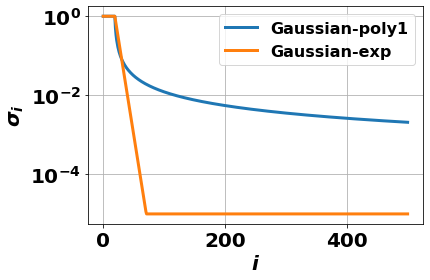

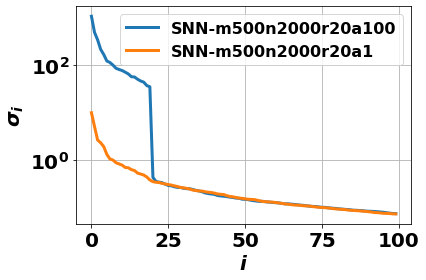

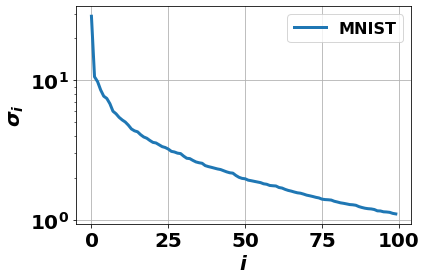

odict_keys(['Gaussian-poly1', 'Gaussian-exp', 'SNN-m500n2000r20a100', 'SNN-m500n2000r20a1', 'MNIST'])


In [30]:
def genenrate_mnist_target(size=800):
    '''
    Output
    -----
    * target: dict('A':ndarray(shape=(m,n)), 
                   'U':ndarray(shape=(m,r)), 
                   's':ndarray(shape=(r,)), 
                   'V':ndarray(shape=(n,r)),
                   'tag':string)
    '''
    dataset = datasets.MNIST(root=os.path.join(root_dir,'dataset'), train=False, download=True, transform=transforms.ToTensor())
    dataloader = DataLoader(dataset, batch_size=size, shuffle=True)
    X,_ = next(iter(dataloader))
    X = X.view(size,-1).numpy().astype(np.double)
    X = X / spla.norm(X, ord=2, axis=1, keepdims=True)
    U,s,Vh = spla.svd(X, full_matrices=False, lapack_driver='gesvd')
    target = {'A': X.astype(np.double), 
              'U': U.astype(np.double), 
              's': s.astype(np.double),
              'V': Vh.T.astype(np.double),
              'tag': 'mnist-train%d'%(size)}
    return target


def genenrate_gaussian_target(m=1000, n=1000, rank=1000, spectrum=None):
    '''
    Output
    -----
    * target: dict('A':ndarray(shape=(m,n)), 
                   'U':ndarray(shape=(m,r)), 
                   's':ndarray(shape=(r,)), 
                   'V':ndarray(shape=(n,r)),
                   'tag':string)
    '''
    if spectrum is None:
        spectrum = np.linspace(1.0, 1e-5, num=rank)
    elif len(spectrum)<rank:
        spectrum = np.concatenate((spectrum, np.zeros(rank-len(spectrum))))
    U,_ = spla.qr(np.random.randn(m,rank), mode='economic')
    V,_ = spla.qr(np.random.randn(n,rank), mode='economic')
    target = {'A': (( U*(spectrum[:rank].reshape((1,-1))) )@V.T).astype(np.double), 
              'U': U.astype(np.double), 
              's': spectrum[:rank].astype(np.double),
              'V': V.astype(np.double),
              'tag': 'Gaussian'}
    return target


def generate_sparse_nonnegative_target(m=1000, n=5000, r1=20, amp=10., sparsity=0.05):
    r = min(m,n)
    weights = np.concatenate((amp/np.arange(1,r1+1), 1./np.arange(r1+1,r+1))) #(r,)
    X = sparse.random(m, r, density=sparsity, format='csr').toarray()
    Y = sparse.random(m, r, density=sparsity, format='csr').toarray()
    A = (X@(weights*Y))
    U,s,Vh = spla.svd(A, full_matrices=False, lapack_driver='gesvd')
    target = {'A': A.astype(np.double), 
              'U': U.astype(np.double), 
              's': s.astype(np.double),
              'V': Vh.T.astype(np.double),
              'tag': f'SNN-m{m:d}n{n:d}r{r1:d}a{amp:.0f}'}
    return target


def visualize_spec(spectra, range=100):
    plt.figure()
    for name, spec in spectra.items():
        plt.semilogy(spec[:range], label=name)
    plt.xlabel('$i$')
    plt.ylabel('$\sigma_i$')
    plt.legend()
    plt.show()


def get_targets(m=500, n=2000, r1=20, verbose=False, tol=1e-5):
    spectra= {  'poly0d5': lambda r: np.concatenate((np.ones(r1), np.maximum(tol,1./(np.arange(2,r-r1+2))**.5))),
                'poly1': lambda r: np.concatenate((np.ones(r1), np.maximum(tol,1./np.arange(2,r-r1+2)))),
                'poly2': lambda r: np.concatenate((np.ones(r1), np.maximum(tol,1./(np.arange(2,r-r1+2))**2))),
                'exp': lambda r: np.concatenate((np.ones(r1), np.maximum(tol,0.8**(np.arange(1,r-r1+1))))),
              }
    targets = OrderedDict()
    # Gaussian random
    spectra_gaussian = dict()
    r = min(m,n)
    for decay in ['poly1','exp']:
        tag = f'Gaussian-{decay:s}'
        targets[tag] = genenrate_gaussian_target(m=m, n=n, rank=r, spectrum=spectra[decay](r))
        targets[tag]['tag'] = tag 
        spectra_gaussian[tag] = targets[tag]['s']
    # SNN
    spectra_snn = dict()
    for amp in [100,1]:
        tag = f'SNN-m{m:d}n{n:d}r{r1:d}a{amp:.0f}'
        targets[tag] = generate_sparse_nonnegative_target(m, n, r1, amp, sparsity=0.05)
        spectra_snn[tag] = targets[tag]['s']
    # MNIST
    N = 2000
    targets['MNIST'] = genenrate_mnist_target(size=N)
    if verbose:
        visualize_spec(spectra_gaussian, range=500)
        visualize_spec(spectra_snn, range=100)
        visualize_spec({'MNIST':targets['MNIST']['s']}, range=100)

    return targets


targets = get_targets(verbose=True)
print(targets.keys())

# Blocked RLUPP

In [31]:
def blocked_rlupp_id_local(A, tol, b=10, mode='lu', record_error=True, verbose=False):
    '''
    mode: 'id' / 'lu'
    '''
    A = A.astype(np.double)
    sample = get_sketch(A, b)
    residual = sample
    skeletons = np.array([])
    candidates = np.arange(A.shape[0]).astype(int)
    W = None
    L = None

    errs_est = []
    errs_id = []
    errs_sid = []

    for t in range(A.shape[0]//b):
        L_t, U_t, p_row = lupp(residual) # residual(m-bt,b), L_t(m-bt,b), U_t(b,b), p_row(m-bt,)
        
        # interpolation matrix
        W_local = np.zeros((A.shape[0], b))
        W_sub = spla.solve_triangular(L_t[:b,:].T, L_t[b:,:].T).T # 'tri_solv'
        # W_sub = matdivide(L_t[b:,:], L_t[:b,:]) # 'stable_inv'
        W_local[candidates[p_row],:] = np.vstack((np.eye(b, dtype=np.double), W_sub))
        if W is None:
            W = W_local 
        else: 
            W[candidates[p_row],:] = W[candidates,:]
            W = np.hstack((W, W_local)) # (m, b(t+1))
        W = W.astype(np.double)
        
        # LU
        if L is None:
            L = L_t  
        else: 
            candidates_local = np.arange(len(skeletons), A.shape[0], dtype=int) #(m-bt,)
            L[candidates_local,:] = L[candidates_local[p_row],:]
            L = np.hstack((L, np.vstack((np.zeros((A.shape[0]-L_t.shape[0],b), dtype=np.double), L_t))))
        L = L.astype(np.double) # (m, b(t+1))
                
        # skeleton indices
        skeletons = np.concatenate((skeletons, candidates[p_row[:b]])).astype(int) # (b(t+1),)
        candidates = candidates[p_row[b:]].astype(int) # (b(m-t-1),)
        
        sample = get_sketch(A, b)
        if mode=='id':
            residual = sample[candidates,:] - W[candidates,:] @ sample[skeletons,:]
            # residual = sample[candidates,:] - matdivide(A[candidates,:], A[skeletons,:]) @ sample[skeletons,:] # stable but slow
        elif mode=='lu':
            L1_t = L[:L.shape[1],:]
            L2_t = L[L.shape[1]:,:]
            residual = sample[candidates,:] - L2_t @ spla.solve_triangular(L1_t, sample[skeletons,:], lower=True)
        else:
            raise ValueError(f'Mode {mode:s} undefined. Available choices: id / lu')
        
        err_est = spla.norm(residual, ord='fro')
        err_id = spla.norm(A - W @ A[skeletons,:], ord='fro')
        err_sid = stable_id_error(A, skeletons)
        
        errs_est.append(err_est)
        errs_id.append(err_id)
        errs_sid.append(err_sid)
        
        if err_est < tol:
            break
        elif verbose:
            print(f'Iteration {t:3d} | Approx rank = {len(skeletons):d} | Error estimation = {err_est:6.2e} | Stable ID error = {err_sid:6.2e}')
    
    ranks = np.arange(1,t+2)*b     
    errs_est = np.array(errs_est)
    errs_id = np.array(errs_id)
    errs_sid = np.array(errs_sid)

    if record_error:
        return W, skeletons, candidates, ranks, errs_est, errs_id, errs_sid
    else: 
        return W, skeletons, candidates
   
   
def blocked_rlupp_id(A, tol, b=10, record_error=True, verbose=False, num_smp=5):
    A = A.astype(np.double)
    sample = get_sketch(A, b)
    residual = sample
    skeletons = np.array([])
    candidates = np.arange(A.shape[0]).astype(int)
    W = None
    L = None

    errs_est = []
    errs_id = []
    errs_sid = []

    for t in range(A.shape[0]//b):
        L_t, _, p_row = lupp(residual) # residual(m-bt,b), L_t(m-bt,b), U_t(b,b), p_row(m-bt,)
        
        # LU
        if L is None:
            L = L_t  
        else: 
            candidates_local = np.arange(len(skeletons), A.shape[0], dtype=int) #(m-bt,)
            L[candidates_local,:] = L[candidates_local[p_row],:]
            L = np.hstack((L, np.vstack((np.zeros((A.shape[0]-L_t.shape[0],b), dtype=np.double), L_t))))
        L = L.astype(np.double) # (m, b(t+1))
                
        # skeleton indices
        skeletons = np.concatenate((skeletons, candidates[p_row[:b]])).astype(int) # (b(t+1),)
        candidates = candidates[p_row[b:]].astype(int) # (b(m-t-1),)
        err_sid = stable_id_error(A, skeletons)
        
        # unbiased estimate
        L1_t = L[:L.shape[1],:]
        L2_t = L[L.shape[1]:,:]
        err_estimates = []
        for _ in range(num_smp):
            sample = get_sketch(A, b)
            residual = sample[candidates,:] - L2_t @ spla.solve_triangular(L1_t, sample[skeletons,:], lower=True)
            err_est = spla.norm(residual, ord='fro')
            err_estimates.append(err_est)
        
        # ID
        ID_residual = A[candidates,:] - L2_t @ spla.solve_triangular(L1_t, A[skeletons,:], lower=True)
        err_id = spla.norm(ID_residual, ord='fro')
        
        errs_est.append(err_estimates)
        errs_id.append(err_id)
        errs_sid.append(err_sid)
        
        if err_est < tol:
            break
        elif verbose:
            print(f'Iteration {t:3d} | Approx rank = {len(skeletons):d} | Error estimation = {(sum(err_estimates)/len(err_estimates)):6.2e} | Stable ID error = {err_sid:6.2e}')
    
    ranks = np.arange(1,len(errs_sid)+1)*b 
    errors = {
        'IRMS_ID': np.array(errs_id),
        'IRMS_EST': np.array(errs_est).T,
        'IRMS_Stable': np.array(errs_sid),
    }

    if record_error:
        return W, skeletons, candidates, ranks, errors
    else: 
        return W, skeletons, candidates
   

# RLUPP v.s. RCPQR, ID v.s. QRID v.s. Stable ID

In [147]:
def qrid_lupp(A, Y, ranks, oversampling=1.0):
    qrid_lupp_errors = []
    qrid_lupp_times = []
    for k in ranks:
        _, _, row_perm = lupp(Y[:,:k]) #(m,k) cost: (mk^2)
        t0 = time.time()
        l = int(np.ceil(k*oversampling))
        R = spla.qr(Y[row_perm][:,:l].T, mode='r') #cost: (ml^2)
        R = R[0] #(k,m)
        R1 = R[:k,:k] #(k,k)
        R2 = R[:k,k:] #(k,m-k)
        W_qr_sub = spla.solve_triangular(R1, R2).T #(m-k,k)
        dt = time.time() - t0
        error = spla.norm(A[row_perm[k:]] - W_qr_sub @ A[row_perm[:k]], ord='fro')
        qrid_lupp_errors.append(error)  
        qrid_lupp_times.append(dt)
    return np.array(qrid_lupp_errors), np.array(qrid_lupp_times)


def qrsid_lupp(A, luppY, ranks):
    qrsid_lupp_errs = []
    qrsid_lupp_times = []
    _, _, row_perm = luppY
    for k in ranks:
        t0 = time.time()
        As = A[row_perm[:k]].T #(n,k)
        Q, R = spla.qr(As, mode='economic',) #(n,k), (k,k)
        W_sub = spla.solve_triangular(R, (A[row_perm[k:]]@Q).T).T #(m-k,k)
        dt = time.time() - t0
        error = spla.norm(A[row_perm[k:]] - W_sub @ A[row_perm[:k]], ord='fro')
        qrsid_lupp_errs.append(error)
        qrsid_lupp_times.append(dt)
    return np.array(qrsid_lupp_errs), np.array(qrsid_lupp_times)


def qrfsid_lupp(A, Y, luppY, ranks, oversampling=1.0):
    qrfsid_lupp_errs = []
    qrfsid_lupp_times = []
    _, _, row_perm = luppY
    for k in ranks:
        l = int(np.ceil(k*oversampling))
        Y_loc = Y[:,:l]
        t0 = time.time()
        Ys = Y_loc[row_perm[:k]].T #(n,k)
        Q, R = spla.qr(Ys, mode='economic',) #(n,k), (k,k)
        W_sub = spla.solve_triangular(R, (Y_loc[row_perm[k:]]@Q).T).T #(m-k,k)
        dt = time.time() - t0
        error = spla.norm(A[row_perm[k:]] - W_sub @ A[row_perm[:k]], ord='fro')
        qrfsid_lupp_errs.append(error)
        qrfsid_lupp_times.append(dt)
    return np.array(qrfsid_lupp_errs), np.array(qrfsid_lupp_times)


def id_lupp(A, luppY, ranks):
    id_lupp_errs = []
    id_lupp_times = []
    L, _, row_idx_lupp = luppY
    for r in ranks: 
        t0 = time.time()
        W_lupp_sub = spla.solve_triangular(L[:r,:r].T, L[r:,:r].T).T
        dt = time.time() - t0
        err = spla.norm(A[row_idx_lupp[r:]] - W_lupp_sub @ A[row_idx_lupp[:r],:], ord='fro')
        id_lupp_errs.append(err)
        id_lupp_times.append(dt)
    return np.array(id_lupp_errs), np.array(id_lupp_times)
        

def sid_lupp(A, luppY, ranks):
    sid_lupp_errs = []
    sid_lupp_times = []
    _, _, row_idx_lupp = luppY
    for r in ranks: 
        error, dt = stable_id_error(A, row_idx_lupp[:r], timing=True)
        sid_lupp_errs.append(error)
        sid_lupp_times.append(dt)
    return np.array(sid_lupp_errs), np.array(sid_lupp_times)


def id_cpqr(A, Y, ranks):
    id_cpqr_errs = []
    id_cpqr_times = []
    for r in ranks: 
        _, R, row_idx_cpqr = cpqr(Y[:,:r].T) # QR has to be computed per-rank since each pivot is determined by a global search
        t0 = time.time()
        W_cpqr_sub = spla.solve_triangular(R[:r,:r], R[:r,r:]).T
        dt = time.time() - t0
        id_cpqr_errs.append(spla.norm(A[row_idx_cpqr[r:]] - W_cpqr_sub @ A[row_idx_cpqr[:r]], ord='fro'))
        id_cpqr_times.append(dt)
    return np.array(id_cpqr_errs), np.array(id_cpqr_times)


def detid_cpqr(A, ranks):
    detid_cpqr_errs = []
    detid_cpqr_times = []
    _, R, row_idx_cpqr = cpqr(A.T) #(m,m) if m<n else (n,m)
    for r in ranks:  
        t0 = time.time()
        W_cpqr_sub = spla.solve_triangular(R[:r,:r], R[:r,r:]).T #(m-r, r)
        dt = time.time() - t0
        detid_cpqr_errs.append(spla.norm(A[row_idx_cpqr[r:]] - W_cpqr_sub @ A[row_idx_cpqr[:r]], ord='fro'))
        detid_cpqr_times.append(dt)
    return np.array(detid_cpqr_errs), np.array(detid_cpqr_times)
        
        
def sid_cpqr(A, Y, ranks):
    sid_cpqr_errs = []
    sid_cpqr_times = []
    for r in ranks: 
        _, _, row_idx_cpqr = cpqr(Y[:,:r].T) # QR has to be computed per-rank since each pivot is determined by a global search
        error, dt = stable_id_error(A, row_idx_cpqr[:r], timing=True)
        sid_cpqr_errs.append(error)
        sid_cpqr_times.append(dt)
    return np.array(sid_cpqr_errs), np.array(sid_cpqr_times)


def u_est_lupp(A, luppY, ranks, u_est_offset=5):
    u_lupp_est_errs = []
    u_lupp_est_times = []
    _, U, _ = luppY
    for r in ranks: 
        # U-est
        t0 = time.time()
        if r<np.min(U.shape):
            offset = min(r+u_est_offset, np.min(U.shape))-r
            # u_est = spla.norm(U[r,r:], ord=2)
            # u_est = spla.norm(U[r:,r:], axis=1, ord=2).max()
            # u_est = spla.norm(U[r:,r:], ord='fro')
            # u_est = spla.norm(U[r, r:], ord=2)
            # u_est = spla.norm(U[r:r+offset, r:r+offset], axis=1, ord=2).max()
            u_est = spla.norm(U[r:r+offset, r:r+offset], ord='fro')
        else:
            offset = 1
            u_est = np.abs(U[-1,-1])
        dt = time.time() - t0
        u_lupp_est_errs.append(u_est * np.sqrt((A.shape[0]-r) * offset))
        u_lupp_est_times.append(dt)
    return np.array(u_lupp_est_errs), np.array(u_lupp_est_times)
    

def get_id_error(A, ranks, u_est_offset=5, oversampling=1.0):
    A = A.astype(np.double)
    Y = get_sketch(A, ranks[-1]).astype(np.double)    
    L, U, row_idx_lupp = lupp(Y)
    id_func_dict = {
        'LUPP_ID': partial(id_lupp, A, (L, U, row_idx_lupp)), 
        'CPQR_ID': partial(id_cpqr, A, Y),
        'LUPP_QRID': partial(qrid_lupp, A, Y, oversampling=oversampling),
        'LUPP_QRFSID': partial(qrfsid_lupp, A, Y, (L, U, row_idx_lupp), oversampling=oversampling),
        'LUPP_QRSID': partial(qrsid_lupp, A, (L, U, row_idx_lupp)),
        'LUPP_Stable': partial(sid_lupp, A, (L, U, row_idx_lupp)),
        'DetCPQR_ID': partial(detid_cpqr, A),
        # 'CPQR_Stable': partial(sid_cpqr, A, Y),
        'U_norm': partial(u_est_lupp, A, (L, U, row_idx_lupp), u_est_offset=u_est_offset),
    }
    
    errors = dict()
    times = dict()
    for tag, id_func in id_func_dict.items():
        error, dt = id_func(ranks)
        errors[tag] = error
        times[tag] = dt
    return errors, times

    
def compare_id_algorithms(target, oversampling=1.0):
    A = target['A']
    tol = 1e-5 * spla.norm(A, ord='fro')

    b = 5
    ranks = np.arange(b, 501, b)
    # W, skeletons, _, ranks, errors = blocked_rlupp_id_local(A, tol, b=b, mode=mode,)
    # W, skeletons, _, ranks, blu_errors = blocked_rlupp_id(A, tol, b=b)
    # print(ranks)
    errors, times = get_id_error(A, ranks, oversampling=oversampling)
    
    errs_svd = [spla.norm(target['s'][r:], ord=2) for r in ranks[:-1].astype(int)]
    if int(ranks[-1])>=len(target['s']):
        errs_svd.append(0.0)
    else:
        errs_svd.append(spla.norm(target['s'][int(ranks[-1]):], ord=2))
    # errors.update(blu_errors)
    errors.update({'SVD': np.array(errs_svd),})
    
    return errors, times, ranks

# Tests

In [202]:
plot_styler = {
    'IRMS_ID': '^:',
    'IRMS_EST': 'd:',
    'IRMS_Stable': '*:',
    'LUPP_ID': 'o-', 
    'LUPP_QRID': 'X-',
    'LUPP_QRSID': 's-',
    'LUPP_QRFSID': 'v-',
    'LUPP_Stable': '*-',
    'U_norm': 'k:',
    'CPQR_ID': 'D-',
    'DetCPQR_ID': 'd-',
    'CPQR_Stable': '*-',
    'IoU_LUPP_CPQR': 'k-',
    'SVD': 'k.-',
}

plot_legends = {
    'IRMS_ID': '$\|\|A-W_k^{BLU}R_k^{BLU}\|\|_{F}$',
    'IRMS_EST': '$\|\|E_k^{BLU}\|\|_F$',
    'IRMS_Stable': '$\|\|A-AQ_{R_k}^{BLU}Q_{R_k}^{BLU*}\|\|_{F}$',
    'LUPP_ID': '$\|\|A-W_k^{LU}R_k^{LU}\|\|_{F}$', 
    'LUPP_QRID': '$\|\|A-W_k^{QRID}R_k^{LU}\|\|_{F}$',
    'LUPP_QRSID': '$\|\|A-W_k^{QRSID}R_k^{LU}\|\|_{F}$', 
    'LUPP_QRFSID': '$\|\|A-W_k^{QRFSID}R_k^{LU}\|\|_{F}$', 
    'LUPP_Stable': '$\|\|A-AQ_{R_k}^{LU}Q_{R_k}^{LU*}\|\|_{F}$',
    'CPQR_ID': '$\|\|A-W_k^{QR}R_k^{QR}\|\|_{F}$',
    'DetCPQR_ID': '$\|\|A-W_k^{DetQR}R_k^{DetQR}\|\|_{F}$',
    'CPQR_Stable': '$\|\|A-AQ_{R_k}^{QR}Q_{R_k}^{QR*}\|\|_{F}$',
    'U_norm': '$\sqrt{(m-k)(l-k)}\|\|U^{LU}\|\|_{F}$',
    'IoU_LUPP_CPQR': 'IoU_LUPP_CPQR',
    'SVD': '$\|\|A - A_k\|\|_{F}$'
}

def plot_mean_variance(xx, yy, key='name', marker='-', markevery=7, color='k', alpha=0.2):
    '''
    xx: (len(xx),)
    yy: (num_smp, len(xx))
    '''
    yy = yy.reshape((-1, len(xx)))
    mean = yy.mean(axis=0)
    std = yy.std(axis=0)
    plt.plot(xx, mean, marker, markevery=markevery, label=f'{key:s}')
    plt.fill_between(xx, mean-std, mean+std, color=color, alpha=alpha)

## Gaussian-poly1

In [203]:
target_tag = 'Gaussian-poly1'
oversampling=1.0
errors, times, ranks = compare_id_algorithms(targets[target_tag], oversampling=oversampling)

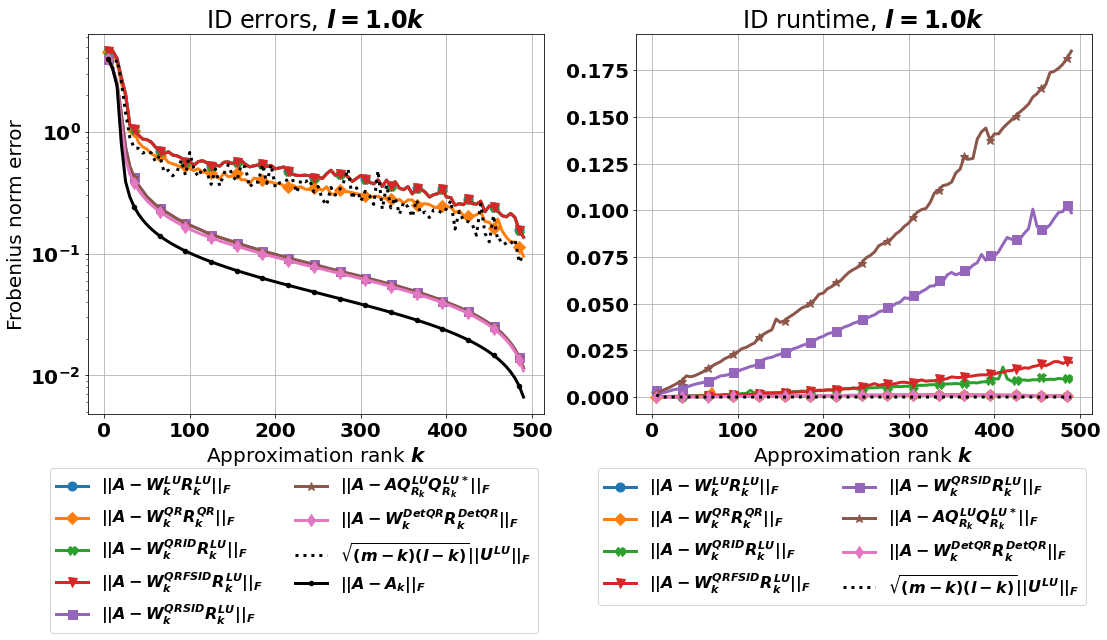

In [204]:
max_x = 490
mask = ranks<=max_x
markevery = 6
lgds = []

plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
for err_key, err_val in errors.items():
    if err_key=='IRMS_EST':
        plot_mean_variance(
            ranks[mask], err_val[:,mask], 
            key=plot_legends[err_key], 
            marker=plot_styler[err_key], markevery=markevery, 
            color=plot_styler[err_key][0], alpha=0.2,
        )
    else:
        plt.plot(ranks[mask], err_val[mask], plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
        # plt.plot(ranks, err_val, plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
plt.xlabel('Approximation rank $k$')
plt.ylabel('Frobenius norm error')
plt.title(f'ID errors, $l={oversampling:.1f}k$')
ax = plt.gca()
ax.set_yscale('log')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(-0.1, -0.12), ncol=2)
lgds.append(lgd)

plt.subplot(1,2,2)
for err_key, time_val in times.items():
    plt.plot(ranks[mask], time_val[mask], plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
    # plt.plot(ranks, time_val, plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
plt.legend()
plt.xlabel('Approximation rank $k$')
plt.title(f'ID runtime, $l={oversampling:.1f}k$')
ax = plt.gca()
# ax.set_yscale('log')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(-0.1, -0.12), ncol=2)
lgds.append(lgd)

plt.savefig(f'./figs/{target_tag}__rank{ranks[-1]:d}.png', bbox_extra_artists=lgds, bbox_inches='tight')

In [205]:
target_tag = 'Gaussian-poly1'
oversampling=2.0
errors, times, ranks = compare_id_algorithms(targets[target_tag], oversampling=oversampling)

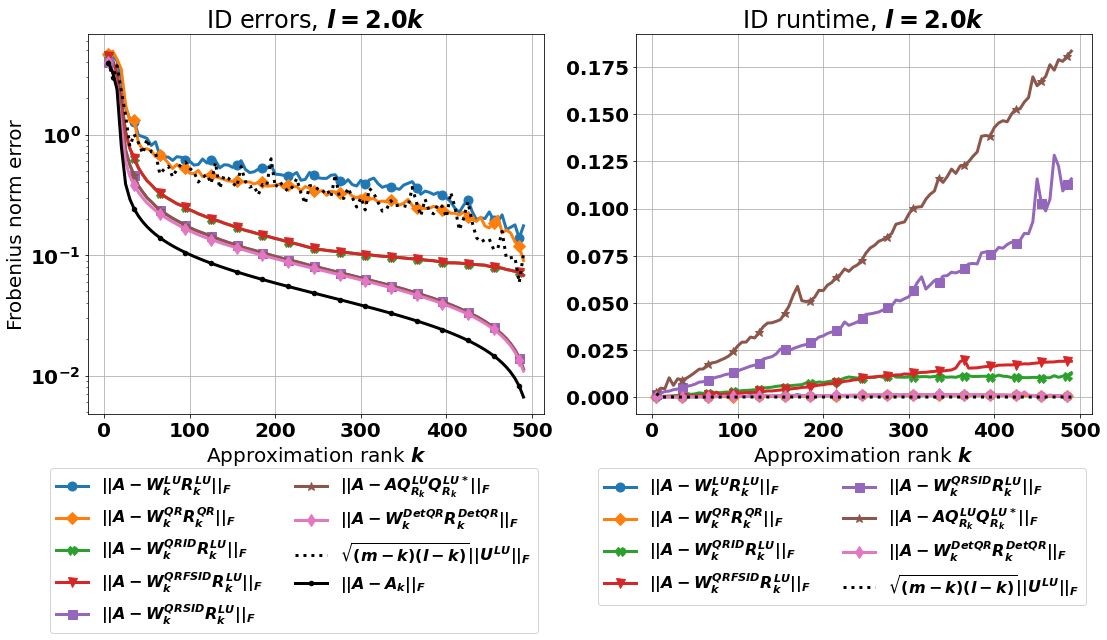

In [206]:
max_x = 490
mask = ranks<=max_x
markevery = 6
lgds = []

plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
for err_key, err_val in errors.items():
    if err_key=='IRMS_EST':
        plot_mean_variance(
            ranks[mask], err_val[:,mask], 
            key=plot_legends[err_key], 
            marker=plot_styler[err_key], markevery=markevery, 
            color=plot_styler[err_key][0], alpha=0.2,
        )
    else:
        plt.plot(ranks[mask], err_val[mask], plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
        # plt.plot(ranks, err_val, plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
plt.xlabel('Approximation rank $k$')
plt.ylabel('Frobenius norm error')
plt.title(f'ID errors, $l={oversampling:.1f}k$')
ax = plt.gca()
ax.set_yscale('log')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(-0.1, -0.12), ncol=2)
lgds.append(lgd)

plt.subplot(1,2,2)
for err_key, time_val in times.items():
    plt.plot(ranks[mask], time_val[mask], plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
    # plt.plot(ranks, time_val, plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
plt.legend()
plt.xlabel('Approximation rank $k$')
plt.title(f'ID runtime, $l={oversampling:.1f}k$')
ax = plt.gca()
# ax.set_yscale('log')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(-0.1, -0.12), ncol=2)
lgds.append(lgd)

plt.savefig(f'./figs/{target_tag}__rank{ranks[-1]:d}.png', bbox_extra_artists=lgds, bbox_inches='tight')

## Gaussian-exp

In [207]:
target_tag = 'Gaussian-exp'
oversampling=1.0
errors, times, ranks = compare_id_algorithms(targets[target_tag], oversampling=oversampling)

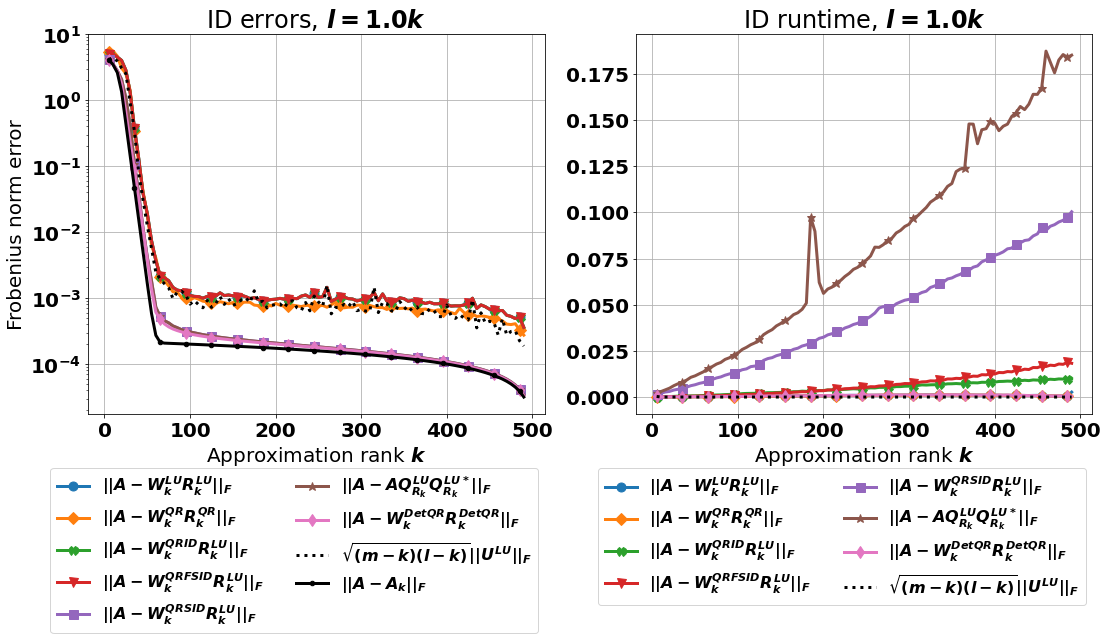

In [208]:
max_x = 490
mask = ranks<=max_x
markevery = 6
lgds = []

plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
for err_key, err_val in errors.items():
    if err_key=='IRMS_EST':
        plot_mean_variance(
            ranks[mask], err_val[:,mask], 
            key=plot_legends[err_key], 
            marker=plot_styler[err_key], markevery=markevery, 
            color=plot_styler[err_key][0], alpha=0.2,
        )
    else:
        plt.plot(ranks[mask], err_val[mask], plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
        # plt.plot(ranks, err_val, plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
plt.xlabel('Approximation rank $k$')
plt.ylabel('Frobenius norm error')
plt.title(f'ID errors, $l={oversampling:.1f}k$')
ax = plt.gca()
ax.set_yscale('log')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(-0.1, -0.12), ncol=2)
lgds.append(lgd)

plt.subplot(1,2,2)
for err_key, time_val in times.items():
    plt.plot(ranks[mask], time_val[mask], plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
    # plt.plot(ranks, time_val, plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
plt.legend()
plt.xlabel('Approximation rank $k$')
plt.title(f'ID runtime, $l={oversampling:.1f}k$')
ax = plt.gca()
# ax.set_yscale('log')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(-0.1, -0.12), ncol=2)
lgds.append(lgd)

plt.savefig(f'./figs/{target_tag}__rank{ranks[-1]:d}.png', bbox_extra_artists=lgds, bbox_inches='tight')

In [209]:
target_tag = 'Gaussian-exp'
oversampling=2.0
errors, times, ranks = compare_id_algorithms(targets[target_tag], oversampling=oversampling)

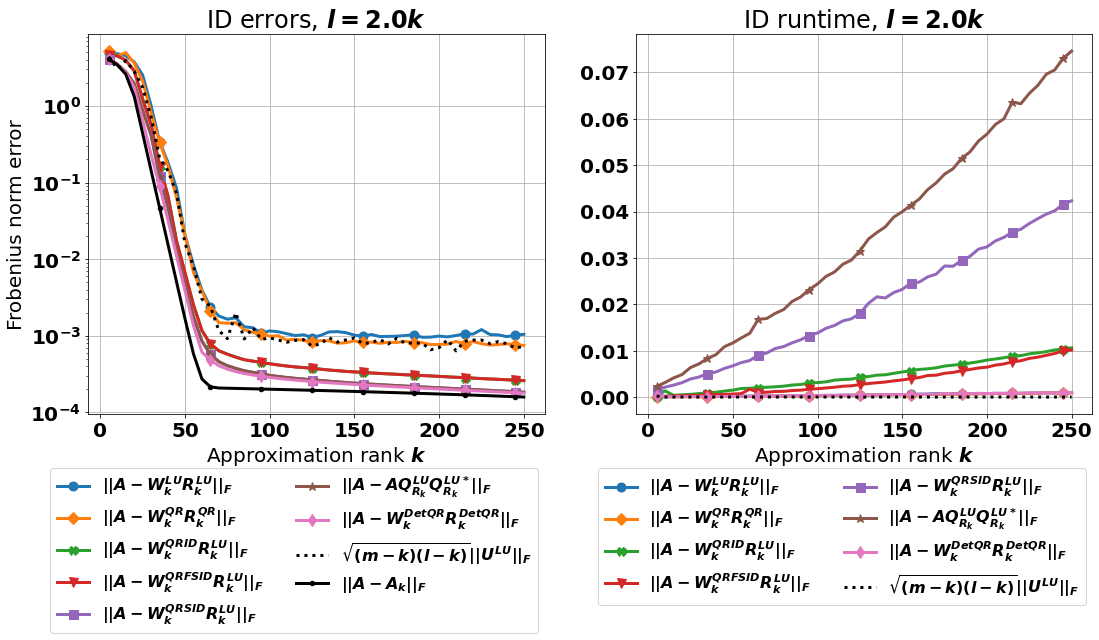

In [210]:
max_x = 250
mask = ranks<=max_x
markevery = 6
lgds = []

plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
for err_key, err_val in errors.items():
    if err_key=='IRMS_EST':
        plot_mean_variance(
            ranks[mask], err_val[:,mask], 
            key=plot_legends[err_key], 
            marker=plot_styler[err_key], markevery=markevery, 
            color=plot_styler[err_key][0], alpha=0.2,
        )
    else:
        plt.plot(ranks[mask], err_val[mask], plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
        # plt.plot(ranks, err_val, plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
plt.xlabel('Approximation rank $k$')
plt.ylabel('Frobenius norm error')
plt.title(f'ID errors, $l={oversampling:.1f}k$')
ax = plt.gca()
ax.set_yscale('log')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(-0.1, -0.12), ncol=2)
lgds.append(lgd)

plt.subplot(1,2,2)
for err_key, time_val in times.items():
    plt.plot(ranks[mask], time_val[mask], plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
    # plt.plot(ranks, time_val, plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
plt.legend()
plt.xlabel('Approximation rank $k$')
plt.title(f'ID runtime, $l={oversampling:.1f}k$')
ax = plt.gca()
# ax.set_yscale('log')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(-0.1, -0.12), ncol=2)
lgds.append(lgd)

plt.savefig(f'./figs/{target_tag}__rank{ranks[-1]:d}.png', bbox_extra_artists=lgds, bbox_inches='tight')

## SNN-r20a100

In [211]:
# target_tag = 'SNN-m500n500r20a100'
target_tag = 'SNN-m500n2000r20a100'
oversampling=1.0
errors, times, ranks = compare_id_algorithms(targets[target_tag], oversampling=oversampling)

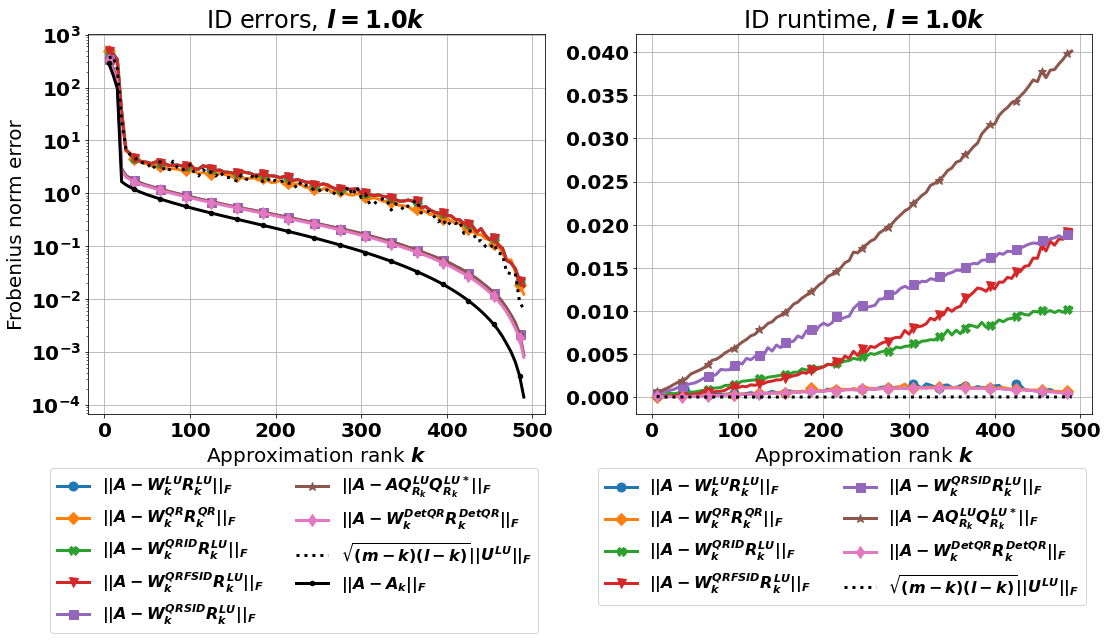

In [212]:
max_x = 490
mask = ranks<=max_x
markevery = 6
lgds = []

plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
for err_key, err_val in errors.items():
    if err_key=='IRMS_EST':
        plot_mean_variance(
            ranks[mask], err_val[:,mask], 
            key=plot_legends[err_key], 
            marker=plot_styler[err_key], markevery=markevery, 
            color=plot_styler[err_key][0], alpha=0.2,
        )
    else:
        plt.plot(ranks[mask], err_val[mask], plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
        # plt.plot(ranks, err_val, plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
plt.xlabel('Approximation rank $k$')
plt.ylabel('Frobenius norm error')
plt.title(f'ID errors, $l={oversampling:.1f}k$')
ax = plt.gca()
ax.set_yscale('log')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(-0.1, -0.12), ncol=2)
lgds.append(lgd)

plt.subplot(1,2,2)
for err_key, time_val in times.items():
    plt.plot(ranks[mask], time_val[mask], plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
    # plt.plot(ranks, time_val, plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
plt.legend()
plt.xlabel('Approximation rank $k$')
plt.title(f'ID runtime, $l={oversampling:.1f}k$')
ax = plt.gca()
# ax.set_yscale('log')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(-0.1, -0.12), ncol=2)
lgds.append(lgd)

plt.savefig(f'./figs/{target_tag}__rank{ranks[-1]:d}.png', bbox_extra_artists=lgds, bbox_inches='tight')

In [213]:
# target_tag = 'SNN-m500n500r20a100'
target_tag = 'SNN-m500n2000r20a100'
oversampling=2.0
errors, times, ranks = compare_id_algorithms(targets[target_tag], oversampling=oversampling)

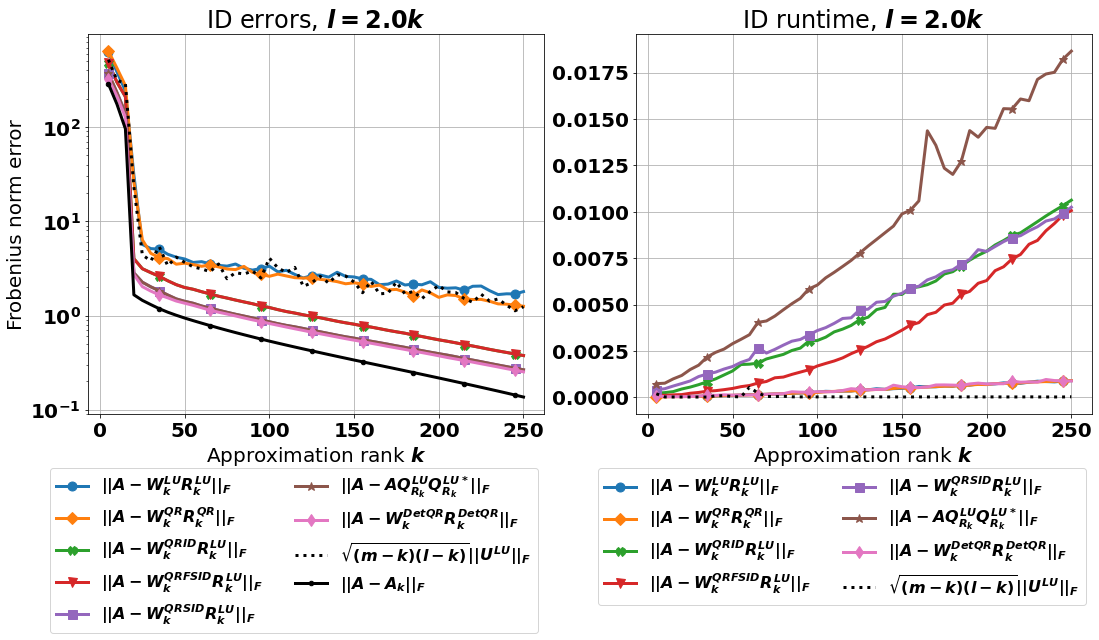

In [214]:
max_x = 250
mask = ranks<=max_x
markevery = 6
lgds = []

plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
for err_key, err_val in errors.items():
    if err_key=='IRMS_EST':
        plot_mean_variance(
            ranks[mask], err_val[:,mask], 
            key=plot_legends[err_key], 
            marker=plot_styler[err_key], markevery=markevery, 
            color=plot_styler[err_key][0], alpha=0.2,
        )
    else:
        plt.plot(ranks[mask], err_val[mask], plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
        # plt.plot(ranks, err_val, plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
plt.xlabel('Approximation rank $k$')
plt.ylabel('Frobenius norm error')
plt.title(f'ID errors, $l={oversampling:.1f}k$')
ax = plt.gca()
ax.set_yscale('log')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(-0.1, -0.12), ncol=2)
lgds.append(lgd)

plt.subplot(1,2,2)
for err_key, time_val in times.items():
    plt.plot(ranks[mask], time_val[mask], plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
    # plt.plot(ranks, time_val, plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
plt.legend()
plt.xlabel('Approximation rank $k$')
plt.title(f'ID runtime, $l={oversampling:.1f}k$')
ax = plt.gca()
# ax.set_yscale('log')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(-0.1, -0.12), ncol=2)
lgds.append(lgd)

plt.savefig(f'./figs/{target_tag}__rank{ranks[-1]:d}.png', bbox_extra_artists=lgds, bbox_inches='tight')

## SNN-m500n500r20a1

In [215]:
# target_tag = 'SNN-m500n500r20a1'
target_tag = 'SNN-m500n2000r20a1'
oversampling=1.0
errors, times, ranks = compare_id_algorithms(targets[target_tag], oversampling=oversampling)

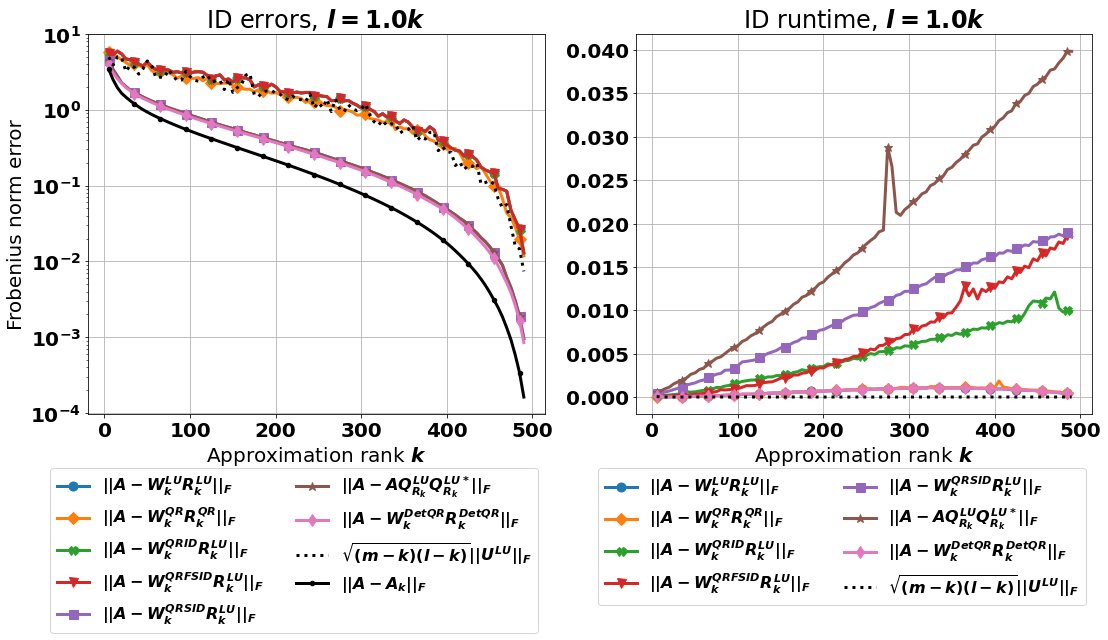

In [216]:
max_x = 490
mask = ranks<=max_x
markevery = 6
lgds = []

plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
for err_key, err_val in errors.items():
    if err_key=='IRMS_EST':
        plot_mean_variance(
            ranks[mask], err_val[:,mask], 
            key=plot_legends[err_key], 
            marker=plot_styler[err_key], markevery=markevery, 
            color=plot_styler[err_key][0], alpha=0.2,
        )
    else:
        plt.plot(ranks[mask], err_val[mask], plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
        # plt.plot(ranks, err_val, plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
plt.xlabel('Approximation rank $k$')
plt.ylabel('Frobenius norm error')
plt.title(f'ID errors, $l={oversampling:.1f}k$')
ax = plt.gca()
ax.set_yscale('log')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(-0.1, -0.12), ncol=2)
lgds.append(lgd)

plt.subplot(1,2,2)
for err_key, time_val in times.items():
    plt.plot(ranks[mask], time_val[mask], plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
    # plt.plot(ranks, time_val, plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
plt.legend()
plt.xlabel('Approximation rank $k$')
plt.title(f'ID runtime, $l={oversampling:.1f}k$')
ax = plt.gca()
# ax.set_yscale('log')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(-0.1, -0.12), ncol=2)
lgds.append(lgd)

plt.savefig(f'./figs/{target_tag}__rank{ranks[-1]:d}.png', bbox_extra_artists=lgds, bbox_inches='tight')

In [217]:
# target_tag = 'SNN-m500n500r20a1'
target_tag = 'SNN-m500n2000r20a1'
oversampling=2.0
errors, times, ranks = compare_id_algorithms(targets[target_tag], oversampling=oversampling)

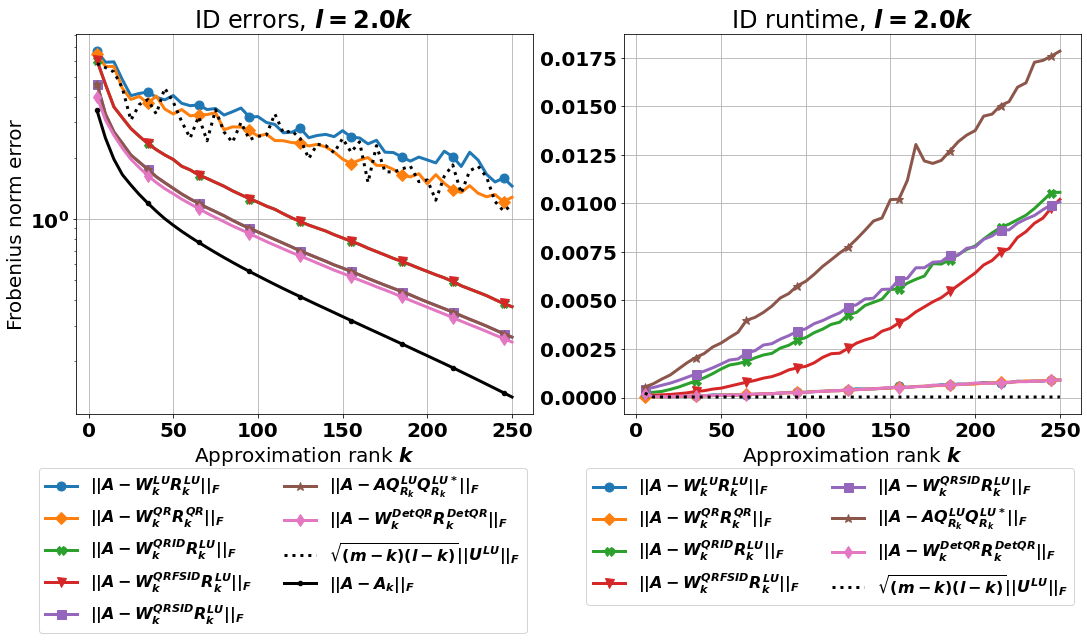

In [218]:
max_x = 250
mask = ranks<=max_x
markevery = 6
lgds = []

plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
for err_key, err_val in errors.items():
    if err_key=='IRMS_EST':
        plot_mean_variance(
            ranks[mask], err_val[:,mask], 
            key=plot_legends[err_key], 
            marker=plot_styler[err_key], markevery=markevery, 
            color=plot_styler[err_key][0], alpha=0.2,
        )
    else:
        plt.plot(ranks[mask], err_val[mask], plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
        # plt.plot(ranks, err_val, plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
plt.xlabel('Approximation rank $k$')
plt.ylabel('Frobenius norm error')
plt.title(f'ID errors, $l={oversampling:.1f}k$')
ax = plt.gca()
ax.set_yscale('log')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(-0.1, -0.12), ncol=2)
lgds.append(lgd)

plt.subplot(1,2,2)
for err_key, time_val in times.items():
    plt.plot(ranks[mask], time_val[mask], plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
    # plt.plot(ranks, time_val, plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
plt.legend()
plt.xlabel('Approximation rank $k$')
plt.title(f'ID runtime, $l={oversampling:.1f}k$')
ax = plt.gca()
# ax.set_yscale('log')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(-0.1, -0.12), ncol=2)
lgds.append(lgd)

plt.savefig(f'./figs/{target_tag}__rank{ranks[-1]:d}.png', bbox_extra_artists=lgds, bbox_inches='tight')

## MNIST

In [219]:
target_tag = 'MNIST'
oversampling=1.0
errors, times, ranks = compare_id_algorithms(targets[target_tag], oversampling=oversampling)

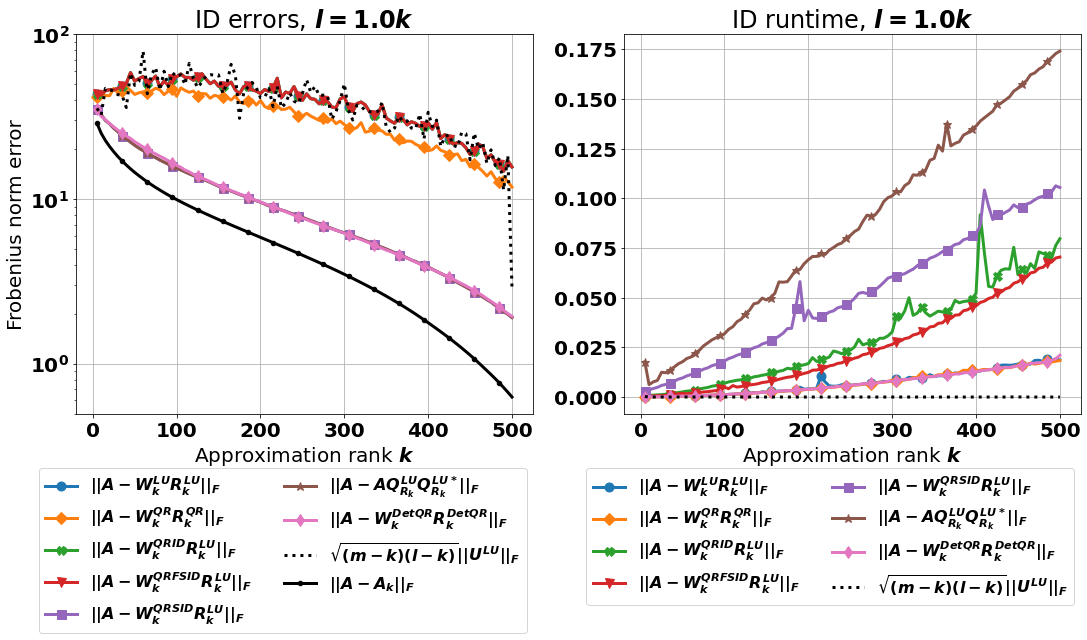

In [220]:
max_x = 600
mask = ranks<=max_x
markevery = 6
lgds = []

plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
for err_key, err_val in errors.items():
    if err_key=='IRMS_EST':
        plot_mean_variance(
            ranks[mask], err_val[:,mask], 
            key=plot_legends[err_key], 
            marker=plot_styler[err_key], markevery=markevery, 
            color=plot_styler[err_key][0], alpha=0.2,
        )
    else:
        plt.plot(ranks[mask], err_val[mask], plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
        # plt.plot(ranks, err_val, plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
plt.xlabel('Approximation rank $k$')
plt.ylabel('Frobenius norm error')
plt.title(f'ID errors, $l={oversampling:.1f}k$')
ax = plt.gca()
ax.set_yscale('log')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(-0.1, -0.12), ncol=2)
lgds.append(lgd)

plt.subplot(1,2,2)
for err_key, time_val in times.items():
    plt.plot(ranks[mask], time_val[mask], plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
    # plt.plot(ranks, time_val, plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
plt.legend()
plt.xlabel('Approximation rank $k$')
plt.title(f'ID runtime, $l={oversampling:.1f}k$')
ax = plt.gca()
# ax.set_yscale('log')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(-0.1, -0.12), ncol=2)
lgds.append(lgd)

plt.savefig(f'./figs/{target_tag}__rank{ranks[-1]:d}.png', bbox_extra_artists=lgds, bbox_inches='tight')

In [221]:
target_tag = 'MNIST'
oversampling=2.0
errors, times, ranks = compare_id_algorithms(targets[target_tag], oversampling=oversampling)

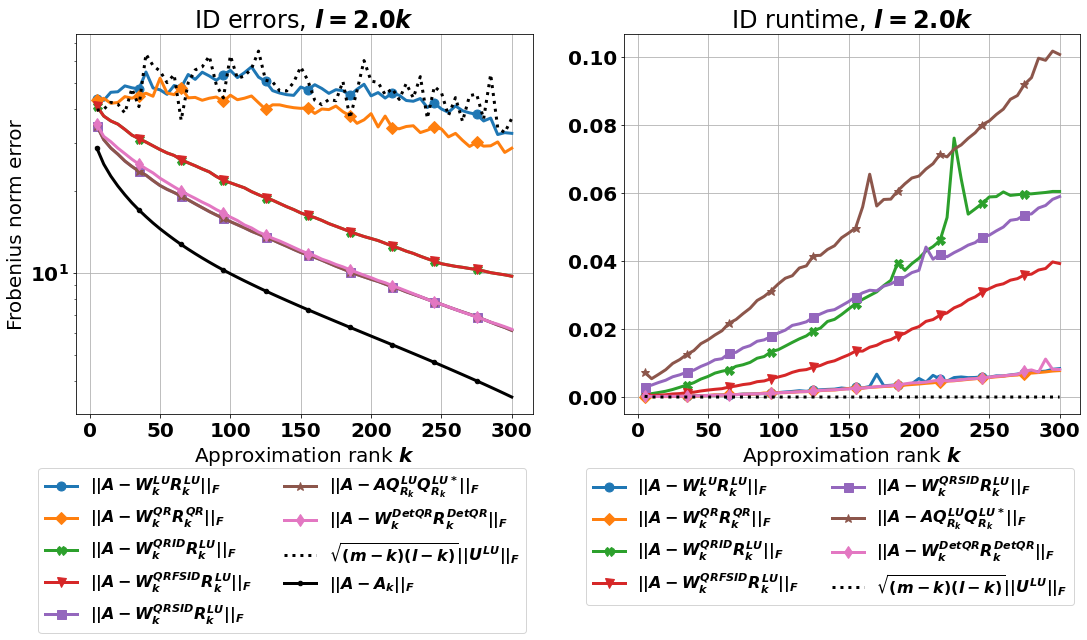

In [222]:
max_x = 300
mask = ranks<=max_x
markevery = 6
lgds = []

plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
for err_key, err_val in errors.items():
    if err_key=='IRMS_EST':
        plot_mean_variance(
            ranks[mask], err_val[:,mask], 
            key=plot_legends[err_key], 
            marker=plot_styler[err_key], markevery=markevery, 
            color=plot_styler[err_key][0], alpha=0.2,
        )
    else:
        plt.plot(ranks[mask], err_val[mask], plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
        # plt.plot(ranks, err_val, plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
plt.xlabel('Approximation rank $k$')
plt.ylabel('Frobenius norm error')
plt.title(f'ID errors, $l={oversampling:.1f}k$')
ax = plt.gca()
ax.set_yscale('log')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(-0.1, -0.12), ncol=2)
lgds.append(lgd)

plt.subplot(1,2,2)
for err_key, time_val in times.items():
    plt.plot(ranks[mask], time_val[mask], plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
    # plt.plot(ranks, time_val, plot_styler[err_key], label=plot_legends[err_key], markevery=markevery)
plt.legend()
plt.xlabel('Approximation rank $k$')
plt.title(f'ID runtime, $l={oversampling:.1f}k$')
ax = plt.gca()
# ax.set_yscale('log')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(-0.1, -0.12), ncol=2)
lgds.append(lgd)

plt.savefig(f'./figs/{target_tag}__rank{ranks[-1]:d}.png', bbox_extra_artists=lgds, bbox_inches='tight')